# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Local library import
We import all the required local libraries libraries

In [28]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries
import yfinance
import scipy.stats
# Import local libraries

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

In [ ]:
data_df = yfinance.download("000300.SS", end="2022-11-06")
data_df.to_csv('CSI300.csv')

In [3]:
CSI300 = yfinance.Ticker("000300.SS")

In [4]:
print(CSI300.info)

{'exchange': 'SHH', 'shortName': 'CSI 300 Index', 'longName': 'CSI 300 Index', 'exchangeTimezoneName': 'Asia/Shanghai', 'exchangeTimezoneShortName': 'CST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '28800000', 'quoteType': 'INDEX', 'symbol': '000300.SS', 'messageBoardId': 'finmb_INDEX000300.SS', 'market': 'cn_market', 'previousClose': 3767.1746, 'regularMarketOpen': 3754.5227, 'twoHundredDayAverage': 3458.44, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 3792.7942, 'navPrice': None, 'averageDailyVolume10Day': 0, 'totalAssets': None, 'regularMarketPreviousClose': 3767.1746, 'fiftyDayAverage': 3458.44, 'trailingAnnualDividendRate': None, 'open': 3754.5227, 'toCurrency': None, 'averageVolume10days': 0, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 3746.3716, 'priceHint': 2, 'currency': 'CNY'

<AxesSubplot:xlabel='Date'>

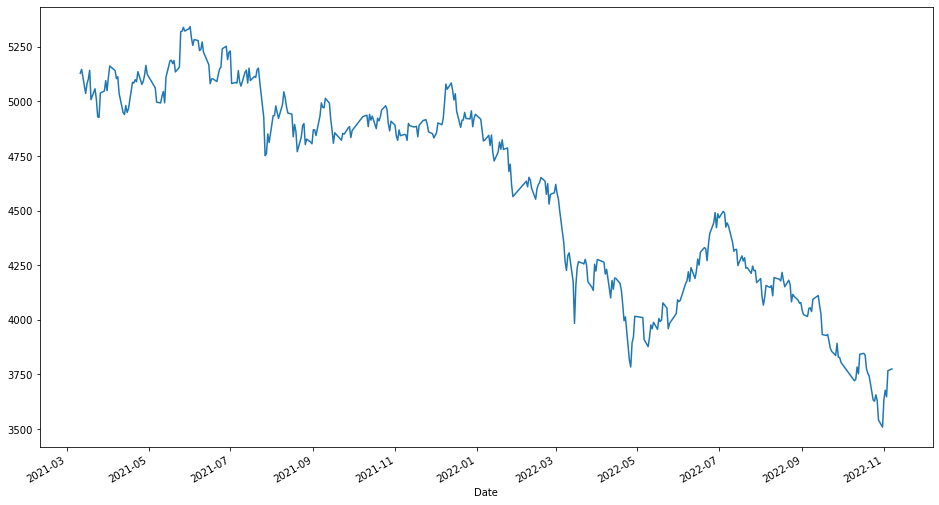

In [5]:
hist = CSI300.history(period = 'max')
hist['Close'].plot(figsize=(16, 9))

In [3]:
data = pd.read_csv("3188_hk_d.csv")
import matplotlib.dates as mdates

In [68]:
data['Date']

0       2012-10-26
1       2012-10-29
2       2012-10-30
3       2012-10-31
4       2012-11-01
           ...    
2464    2022-10-31
2465    2022-11-01
2466    2022-11-02
2467    2022-11-03
2468    2022-11-04
Name: Date, Length: 2469, dtype: object

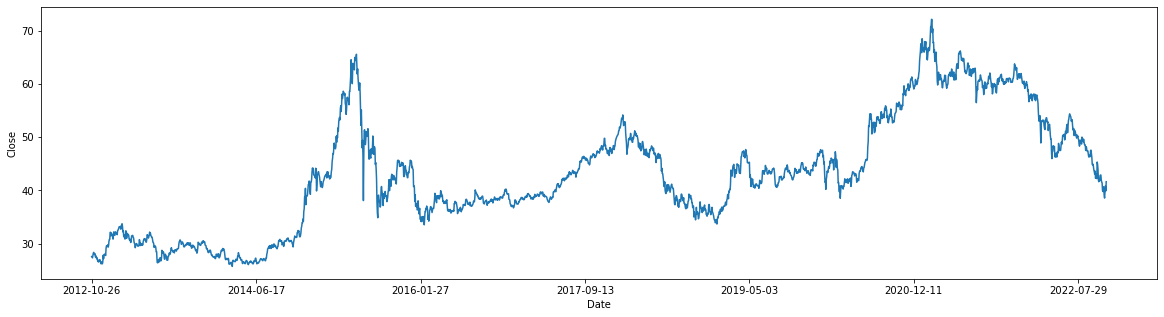

In [4]:
plt.figure(figsize = (20,5))
plt.plot(data['Date'], data['Close'])
plt.xticks(data['Date'][::400])
plt.ylabel('Close')
plt.xlabel('Date')
plt.show()

# Data processing

In [84]:
#returns = data['Close'].pct_change().dropna()
returns = pd.DataFrame({
    'returns': data['Close'].pct_change().dropna(),
    'date': data['Date'][1:],
    'rv': [x**2 for x in returns['returns']]
})
realised_volatility = [x**2 for x in returns['returns']]
print(returns.shape)

(2468, 3)


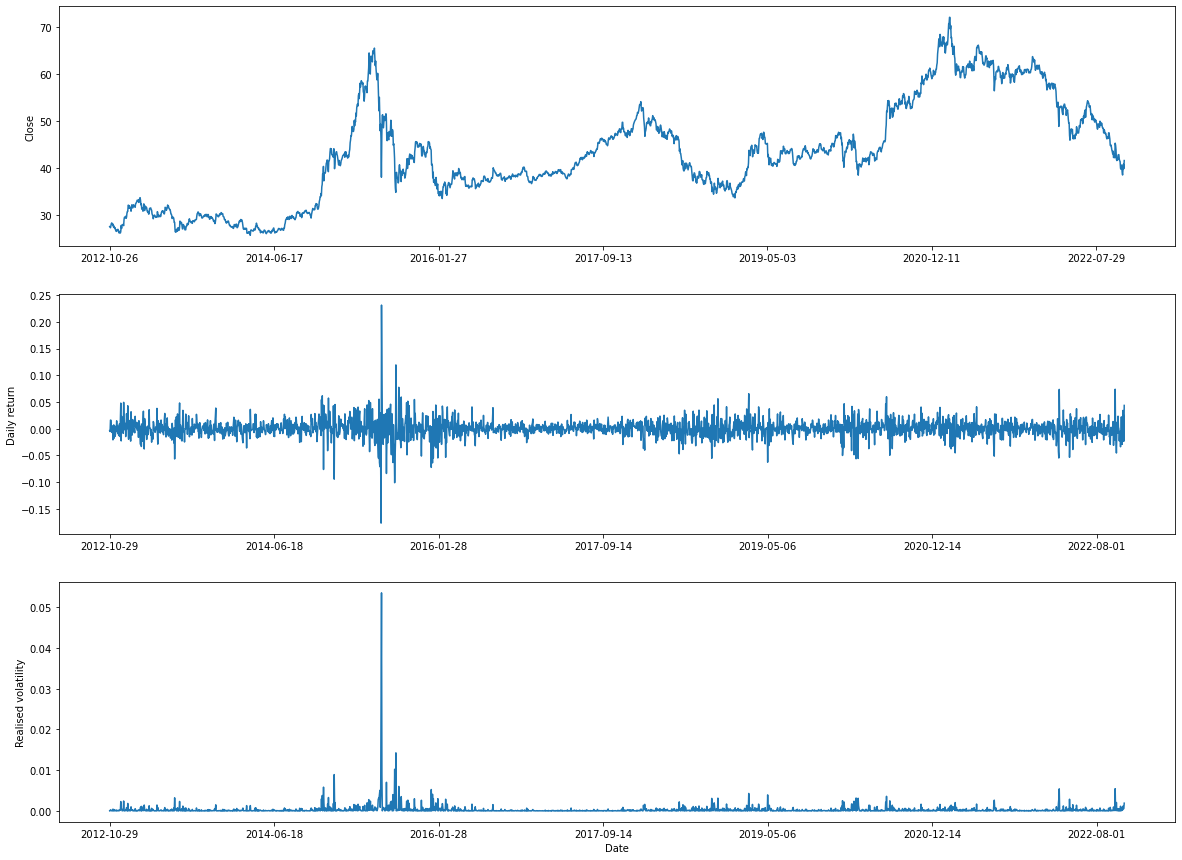

In [65]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(data['Date'], data['Close'])
ax[0].set_xticks(data['Date'][::400])
ax[0].set_ylabel('Close')
#ax.xlabel('Date')

ax[1].plot(returns['date'], returns['returns'])
ax[1].set_xticks(data['Date'][1:][::400])
ax[1].set_ylabel('Daily return')
#ax.xlabel('Date')

ax[2].plot(data['Date'][1:], realised_volatility)
ax[2].set_xticks(data['Date'][1:][::400])
ax[2].set_ylabel('Realised volatility')
ax[2].set_xlabel('Date')

plt.show()

In [66]:
from statsmodels.tsa.stattools import adfuller
data_characteristics = pd.DataFrame()
i = 0
for ind, dat in enumerate([returns['returns'].values, realised_volatility]):
    data_characteristics.loc[ind, 'mean'] = np.mean(dat)
    data_characteristics.loc[ind, 'var'] = np.var(dat)
    data_characteristics.loc[ind, 'skewness'] = scipy.stats.skew(dat)
    data_characteristics.loc[ind, 'kurtuosis'] = scipy.stats.kurtosis(dat)
    data_characteristics.loc[ind, 'Jarque-Bera'] = scipy.stats.jarque_bera(dat)[0]
    data_characteristics.loc[ind, 'ADF'] = adfuller(dat)[0]

In [67]:
data_characteristics

,mean,var,skewness,kurtuosis,Jarque-Bera,ADF
0,0.000317,0.000301,0.496282,20.523936,4.341799e+04,-9.003197
1,0.000301,0.000002,26.078697,874.117716,7.885282e+07,-11.082126


# Try to write HAR models

In [85]:
def HAR(rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(rv.iterrows()):
        if len(rv) - ind>=22:
            #print(x[1]['date'])
            HAR_data.loc[ind, 'date'] = x[1]['date']
            HAR_data.loc[ind, 'rv'] = x[1]['rv']
            HAR_data.loc[ind, 'daily'] = x[1]['returns']
            HAR_data.loc[ind, 'weekly']= np.sum(rv['returns'][ind:ind+5])/5
            HAR_data.loc[ind, 'monthly'] = np.sum(rv['returns'][ind:ind+22])/22
    return HAR_data

def HAR_j(rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(rv.iterrows()):
        if len(rv) - ind<=22:
            HAR_data.loc[ind, 'date'] = x['date']
            HAR_data.loc[ind, 'daily'] = x['returns']
            HAR_data.loc[ind, 'weekly']= np.sum(rv['returns'][ind:ind+5])/5
            HAR_data.loc[ind, 'monthly'] = np.sum(rv['returns'][ind:ind+22])/22
            #I can`t use HAR_j model, because i have only daily information
            #HAR_data.loc[ind, 'jump'] = 
    return HAR_data


HAR(returns)

,date,rv,daily,weekly,monthly
0,2012-10-29,0.000013,-0.003592,0.005659,-0.001675
1,2012-10-30,0.000028,-0.005316,0.004995,-0.002100
2,2012-10-31,0.000261,0.016142,0.004666,-0.001603
3,2012-11-01,0.000251,0.015850,0.002489,-0.001916
4,2012-11-02,0.000027,0.005213,-0.004866,-0.003305
...,...,...,...,...,...
2442,2022-09-29,0.000057,0.007569,0.012619,-0.003895
2443,2022-09-30,0.000149,0.012207,0.006830,-0.002683
2444,2022-10-03,0.000436,-0.020872,-0.004715,-0.002121
2445,2022-10-05,0.005461,0.073899,-0.001971,-0.002240


# Try first model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

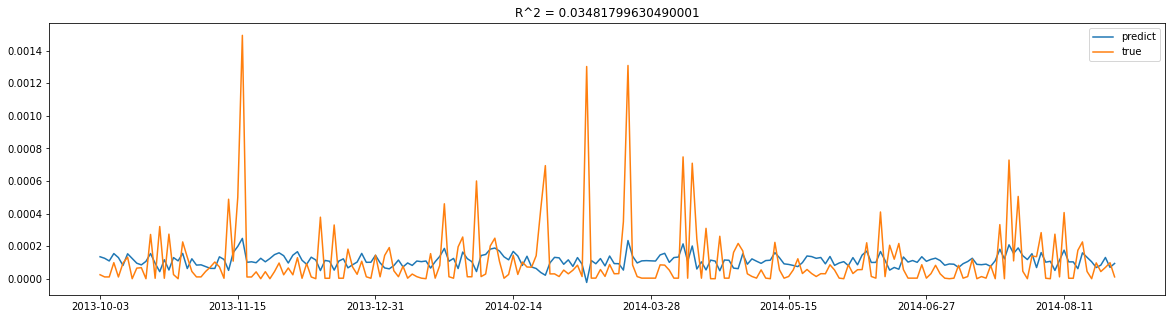

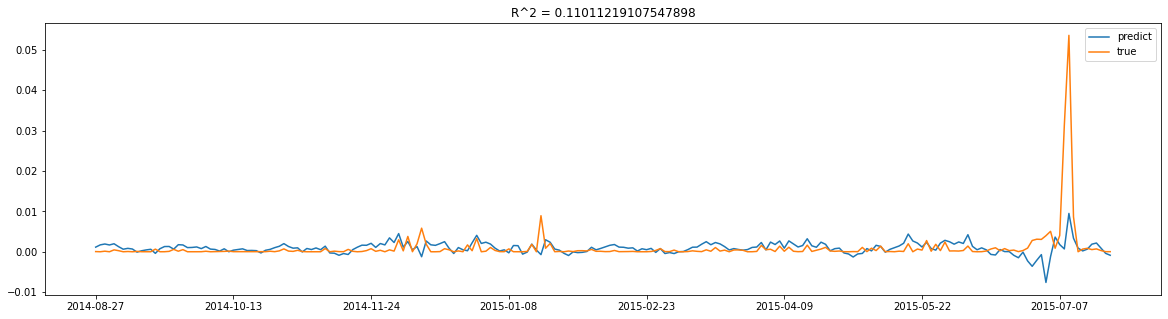

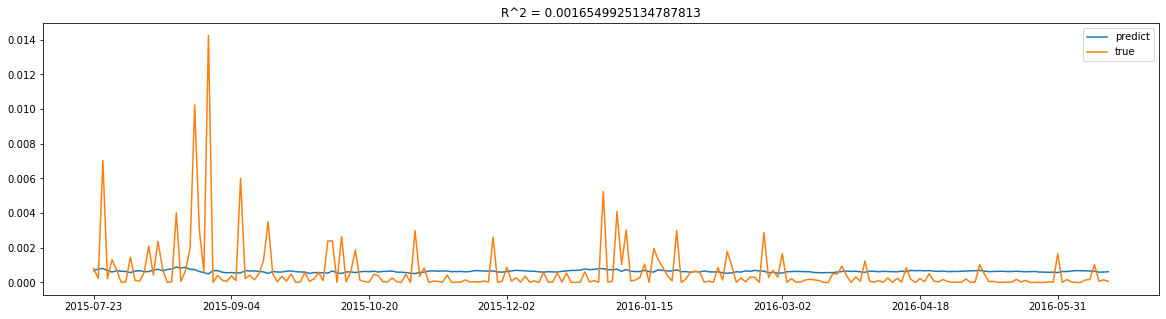

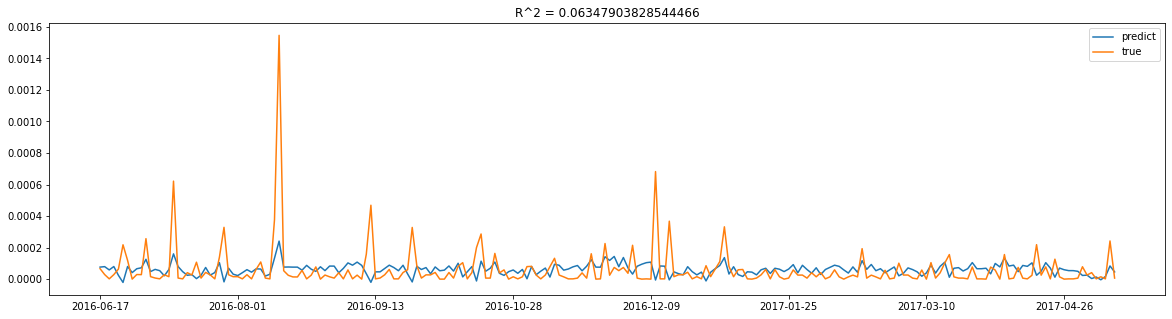

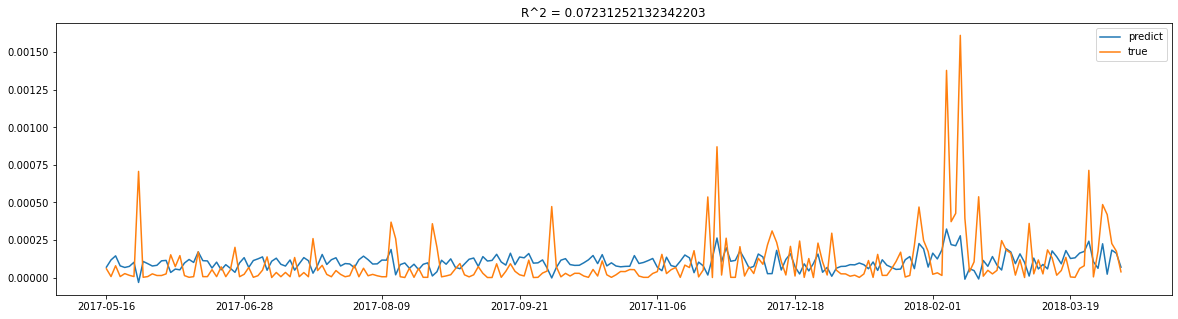

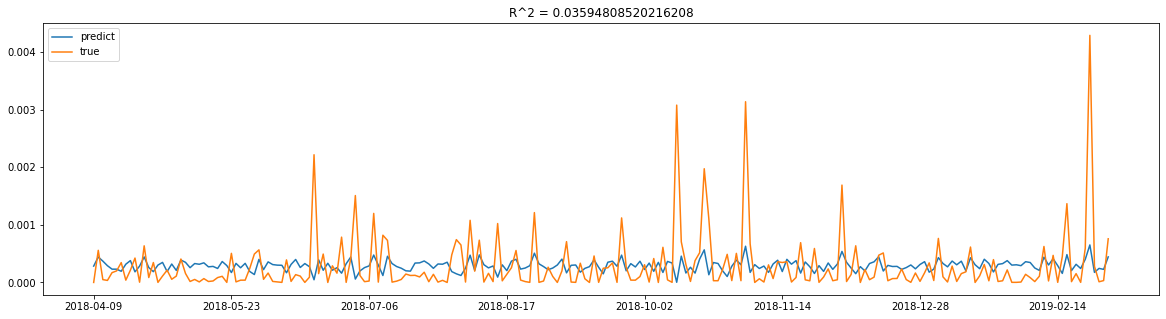

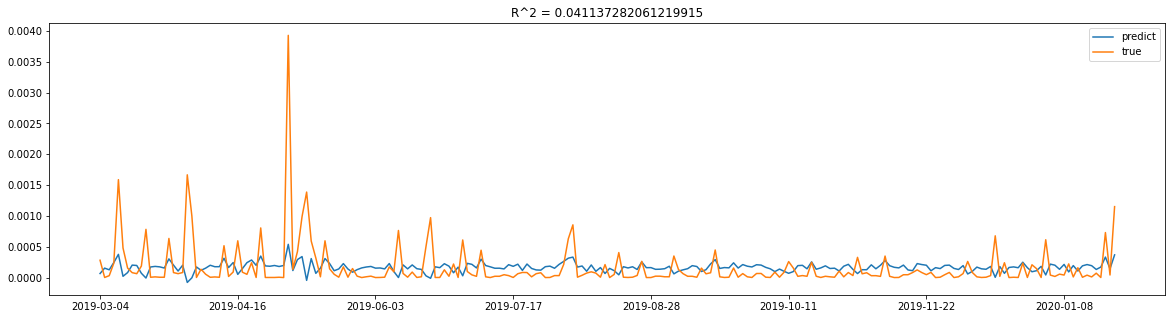

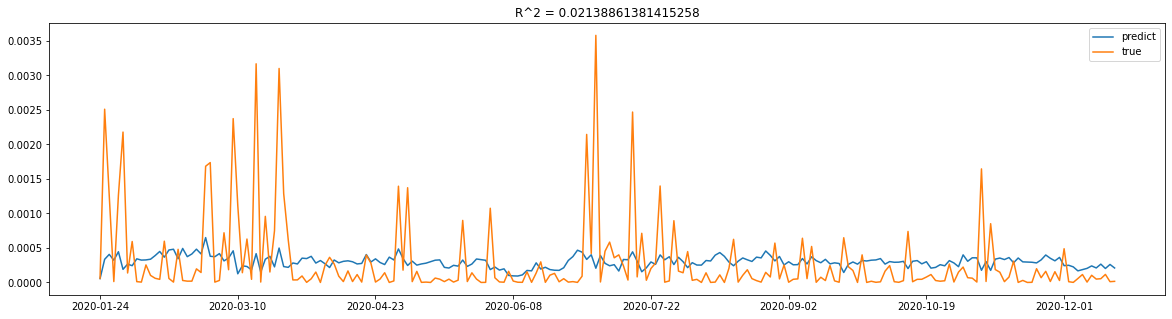

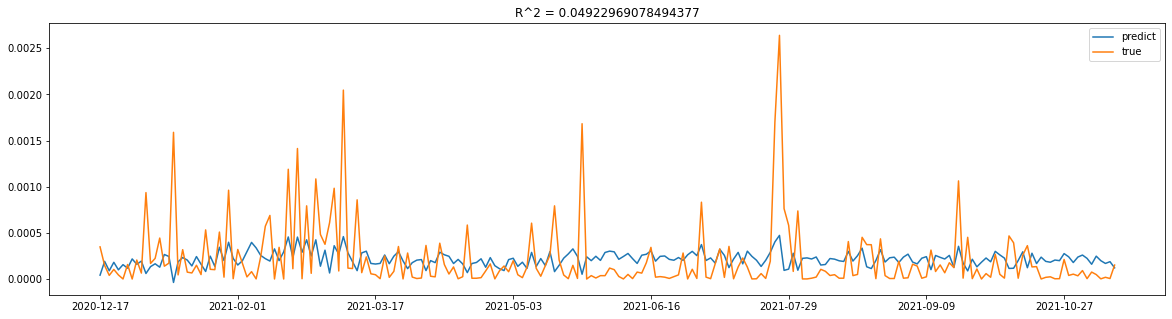

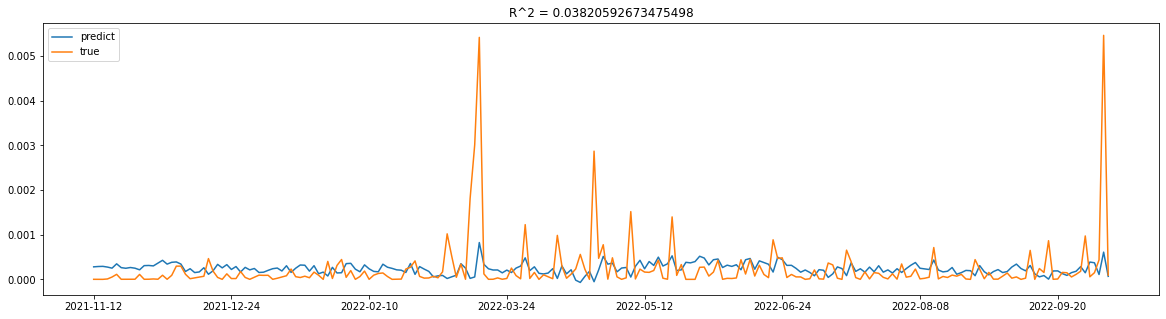

In [93]:
features = ['daily', 'weekly', 'monthly']
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 10)
for train_index, test_index in tscv.split(HAR(returns)):
    cv_train, cv_test = HAR(returns).iloc[train_index], HAR(returns).iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_test, y_test)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()